# Downlink Synchronization in 5G Networks: SSB

The tutorial demonstrates the downlink synchronization using synchronization signal block (SSB) in 5G networks. The SSB consists of 4 elements:

- Primary Synchronization Signal (PSS)
- Secondary Synchronization Signal (SSS)
- Physical Broadacast Channel (PBCH) Payload: 432 symbols
- Demodulation Reference Signal (DMRS) for PBCH

The tutorial performs following procedures:

- Import Libraries
    - [Import Python Libraries](#Import-Python-and-SDR-Libraries)
    - [Import 5G Toolkit Libraries](#Import-5G-Toolkit-Libraries)
- [Emulation Configurations](#Emulation-Configurations)
- [Construct SSB](#Generate-the-SSB-Grid-for-synchronization)
    - Generate PSS
    - Generate PSS
    - Generate PBCH
    - Generate DMRS-PBCH
    - Generate SSB
    - [Constellation Diagram](#Constellation-Diagram)
- [OFDM Modulation](#OFDM-Modulation:-Tx)
    - Insert SSB to Tx Resource Grid
    - OFDM Modulation
- [SDR Configuration](#SDR-Setup-Configurations)
- [Transmit using SDR RF Transmitter](#Transmission:-SDR-RF-Transmitter)
- [Receive using SDR RF Receiver](#Reception:-SDR-RF-Receiver)
    - [Receiver Implementation](#Receiver-Implementation)
- [Time Synchronization](#Time-Synchronization:-Based-on-PSS-Correlation)
- [OFDM Receiver and SSB Grid Extraction](#OFDM-Demodulation-and-SSB-Extraction)
    - [Tx-Rx SSB Grid Comparison](#SSB-Grid:-Transmitter-and-Receiver)
    - [Tx-Rx Spectrum Comparison](#Spectrum:-Transmitted-Grid-and-Received-Grid)
- [Frequency Synchronization]()
- [Parameter Estimation](#Parameter-Estimation-for-SSB-and-PBCH)
- [PBCH Estimates](#Channel-Estimation-and-PBCH-Symbol-Equalization)
    - Channel Estimation
    - Equalization
    
- [PBCH Decoding](#PBCH-Decoding-and-Constellation)
    - MIB Decoding
    - ATI Decoding
    
- [BER Computation](#Performance-Verification)


## Import Libraries
### Import Python and SDR Libraries

In [1]:
# %matplotlib widget

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import matplotlib.pyplot as plt
import numpy as np
import adi


### Import 5G Toolkit Libraries 

In [2]:
from toolkit5G.SequenceGeneration import PSS, SSS, DMRS
from toolkit5G.PhysicalChannels   import PBCH, PBCHDecoder
from toolkit5G.ResourceMapping    import SSB_Grid, ResourceMapperSSB
from toolkit5G.OFDM               import OFDMModulator, OFDMDemodulator
from toolkit5G.MIMOProcessing     import AnalogBeamforming, ReceiveCombining
from toolkit5G.ReceiverAlgorithms import PSSDetection, SSSDetection, ChannelEstimationAndEqualization, DMRSParameterDetection
from toolkit5G.Configurations     import TimeFrequency5GParameters, GenerateValidSSBParameters

## Emulation Configurations

In [3]:
# System Parameters
center_frequency    = 1e9 # Hz

# OFDM Parameters
Bandwidth           = 5*10**6
fftSize             = 1024
subcarrier_spacing  = 15000
numOFDMSymbols      = 14
sample_rate         = fftSize*subcarrier_spacing

# Pulse Shaping
numSamplesPerSymbol = 1


# number of samples returned per call to rx()
buffer_size         = int(fftSize*1.2*numSamplesPerSymbol*numOFDMSymbols) 

## Transmitter Implementation

![SSB Transmitter](images/PBCH_SDR_Tx.svg)

## Generate the SSB Grid for synchronization


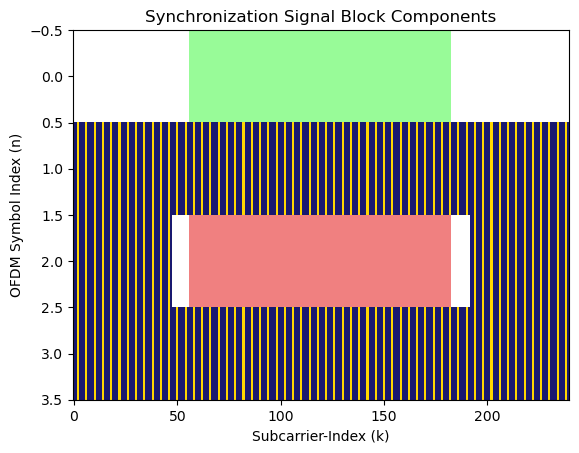

In [4]:
## This class fetches valid set of 5G parameters for the system configurations
nSymbolFrame= int(140*subcarrier_spacing/15000)
tfParams    = TimeFrequency5GParameters(Bandwidth, subcarrier_spacing)
tfParams(nSymbolFrame, typeCP = "normal")
nRB         = 20        # SSB Grid size (Number of RBs considered for SSB transition)
Neff        = nRB*12
lengthCP    = (tfParams.lengthCP*(fftSize/tfParams.Nfft)).astype(np.int32)    # CP length
#___________________________________________________________________

#### Generate MIB Information
lamda                           = 3e8/center_frequency;
nSCSOffset                      = 1
ssbParameters                   = GenerateValidSSBParameters(center_frequency, nSCSOffset, "caseA")

systemFrameNumber               = ssbParameters.systemFrameNumber
subCarrierSpacingCommon         = subcarrier_spacing
ssbSubCarrierOffset             = ssbParameters.ssbSubCarrierOffset
DMRSTypeAPosition               = ssbParameters.DMRSTypeAPosition
controlResourceSet0             = ssbParameters.controlResourceSet0
searchSpace0                    = ssbParameters.searchSpace0

isPairedBand                    = ssbParameters.isPairedBand
nSCSOffset                      = ssbParameters.nSCSOffset
choiceBit                       = ssbParameters.choiceBit
ssbType                         = ssbParameters.ssbType
nssbCandidatesInHrf             = ssbParameters.nssbCandidatesInHrf
ssbIndex                        = ssbParameters.ssbIndex
hrfBit                          = ssbParameters.hrfBit
cellBarred                      = ssbParameters.cellBarred
intraFrequencyReselection       = ssbParameters.intraFrequencyReselection
withSharedSpectrumChannelAccess = ssbParameters.withSharedSpectrumChannelAccess

Nsc_ssb                         = 240
Nsymb_ssb                       = 4
#_______________________________________


N_ID2        = np.random.randint(3)

# Generate PSS sequence
pssObject    = PSS(N_ID2);
pssSequence  = pssObject()

N_ID1        = np.random.randint(336)
N_ID         = 3*N_ID1 + N_ID2

# Generate SSS sequence
sssObject    = SSS(N_ID1, N_ID2);
sssSequence  = sssObject()

# Generate DMRS sequence
dmrsLen      = 144;
dmrsObject   = DMRS("PBCH", N_ID, ssbIndex, nssbCandidatesInHrf, hrfBit)
# dmrsSeq = dmrs.getSequence("tensorflow")
dmrsSequence = dmrsObject(dmrsLen)


# Generate PBCH symbols
pbchObject   = PBCH(center_frequency, choiceBit, subCarrierSpacingCommon, DMRSTypeAPosition,
                   controlResourceSet0, searchSpace0, cellBarred, intraFrequencyReselection,
                   systemFrameNumber, ssbSubCarrierOffset, hrfBit, ssbIndex, N_ID,
                   nssbCandidatesInHrf)

pbchSymbols  = pbchObject()

## Generate SSB Object
ssbObject    = SSB_Grid(N_ID, True)
ssb          = ssbObject(pssSequence, sssSequence, dmrsSequence, pbchSymbols)

## Loading SSB to Resource Grid
#####################################
# ssbPositionInBurst = np.ones(nssbCandidatesInHrf, dtype=int)
ssbPositionInBurst    = np.zeros(nssbCandidatesInHrf, dtype=int)
ssbPositionInBurst[0] = 1

ssbRGobject = ResourceMapperSSB(ssbType=ssbType, carrierFrequency = center_frequency, N_RB=nRB,
                              kssb=0, offsetToPointA = int(nRB*0.5-10),
                              scsCarrier = subCarrierSpacingCommon,
                              ssbPositionInBurst = ssbPositionInBurst, ssbPeriodicity = None, nHF=None,
                              nFrames = 0.1*(subcarrier_spacing/subCarrierSpacingCommon), isPairedBand = isPairedBand,
                              withSharedSpectrumChannelAccess = withSharedSpectrumChannelAccess)

ssbGrid     = ssbRGobject(ssb[0])
fig, ax = ssbObject.displayGrid(option=1)


In [5]:
ssbIndex

array([0, 1, 2, 3])

## Constellation Diagram

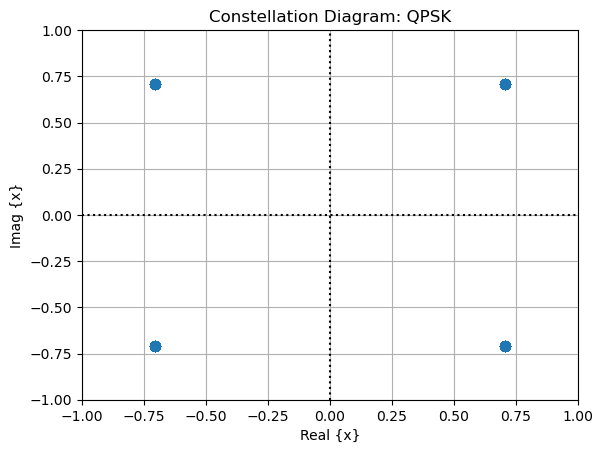

In [6]:
fig, ax = plt.subplots()
ax.scatter(np.real(pbchSymbols),  np.imag(pbchSymbols), s=48)
ax.axhline(y=0, ls=":", c="k")
ax.axvline(x=0, ls=":", c="k")
ax.set_xlim([-1,1])
ax.set_ylim([-1,1])
ax.set_xlabel("Real {x}")
ax.set_ylabel("Imag {x}")
ax.set_title("Constellation Diagram: QPSK")
ax.grid()
plt.show()

## OFDM Modulation: Tx

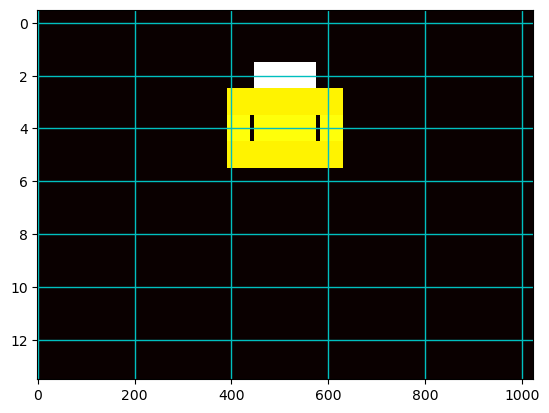

In [7]:
firstSymbolIndex   = int(2)
numofGuardCarriers = (int((fftSize - Neff)/2), int((fftSize - Neff)/2))
offsetToPointA     = 0
firstSCIndex       = int(numofGuardCarriers[0] + offsetToPointA)

X = np.zeros((numOFDMSymbols, fftSize), dtype= np.complex64)
X[:, firstSCIndex:firstSCIndex+240] = ssbGrid

#__________________________________________________

## OFDM Modulation at Transmitter
#####################################
modulator = OFDMModulator(lengthCP[1])
x_time    = modulator(X).flatten()
#______________________________________________________

# Plot Resource Grid
#################################################################
fig, ax = plt.subplots()
plt.imshow(np.abs(X), cmap = 'hot', interpolation='nearest', aspect = "auto")
ax = plt.gca();
ax.grid(color='c', linestyle='-', linewidth=1)
# Gridlines based on minor ticks
plt.show()

## SDR-Setup Configurations

In [8]:
# Basic SDR Setup
sdr = adi.Pluto("ip:192.168.2.1")
sdr.sample_rate = int(sample_rate)

# Config Tx
sdr.tx_rf_bandwidth = int(sample_rate) # filter cutoff, just set it to the same as sample rate
sdr.tx_lo           = int(center_frequency)
sdr.tx_hardwaregain_chan0 = -20 # Increase to increase tx power, valid range is -90 to 0 dB

# Config Rx
sdr.gain_control_mode_chan0 = 'manual'
sdr.rx_hardwaregain_chan0   = 40.0      # dB
# The receive gain on the Pluto has a range from 0 to 74.5 dB.

# sdr.gain_control_mode_chan0 = 'slow_attack'
# # AGC modes: 
#     # 1. "manual"
#     # 2. "slow_attack"
#     # 3. "fast_attack"

sdr.rx_lo           = int(center_frequency)
sdr.rx_rf_bandwidth = int(60*10**6) # filter width, just set it to the same as sample rate for now
sdr.rx_buffer_size  = int(4*buffer_size)

In [9]:
np.abs(1.3*2**17*(x_time.repeat(1))).max(), np.abs(x_time).min()

(14897.936663873787, 0.0)

## Transmission: SDR RF Transmitter

In [10]:

# Start the transmitter
sdr.tx_cyclic_buffer = True # Enable cyclic buffers
# sdr.tx_cyclic_buffer = False # Enable cyclic buffers
sdr.tx(1.3*2**17*(x_time.repeat(1))) # start transmitting


## Receiver Implementation
![Receiver_Implementation](images/PBCH_SDR_Rx.svg)

## Reception: SDR RF Receiver

In [11]:

# Clear buffer just to be safe
for i in range (0, 10):
    raw_data = sdr.rx()

# Receive samples
rx_samples = sdr.rx()

# # Stop transmitting
sdr.tx_destroy_buffer()


## Time Synchronization: Based on PSS Correlation

**(rasterOffset, PSS-ID) (392, 0)
**(rasterOffset, PSS-ID) (392, 1)
**(rasterOffset, PSS-ID) (392, 2)


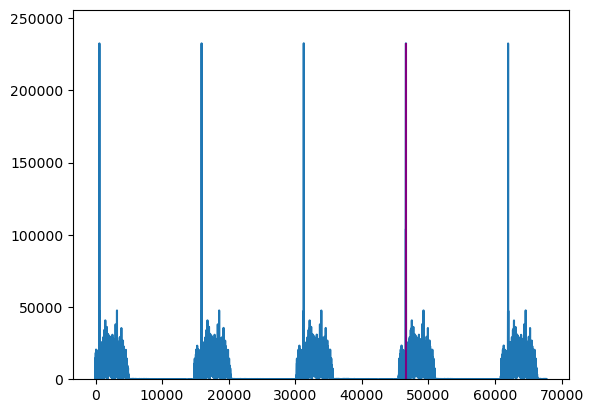

In [12]:
## PSS Detection: Based on time domain PSS Correlation
# pssPeakIndices, pssCorrelation, rN_ID2 = pssDetection(r, Nfft, lengthCP = lengthCP[1],
#                                                       N_ID2 = None, freqOffset = ssboffset,
#                                                       height = 0.75, prominence = 0.65, width=10)
## PSS Detection: Based on time domain PSS Correlation
# pssDetection   = PSSDetection("correlation", "threshold")
pssDetection   = PSSDetection("largestPeak")
ssboffset      = int((fftSize-Neff)/2+ssbRGobject.startingSubcarrierIndices)
pssPeakIndices, pssCorrelation, rN_ID2, freqOffset = pssDetection(rx_samples, fftSize, lengthCP = lengthCP[1],
                                                                  N_ID2 = None, freqOffset = ssboffset)

## PSS Detection Plot
#################################################################
fig, ax = plt.subplots()

# single line
plt.plot(pssCorrelation)
plt.vlines(x = pssPeakIndices, ymin = 0*pssCorrelation[pssPeakIndices],
           ymax = pssCorrelation[pssPeakIndices], colors = 'purple')
plt.ylim([0,np.max(pssCorrelation)*1.1])
plt.show()
#________________________________________________________________

## OFDM Demodulation and SSB Extraction

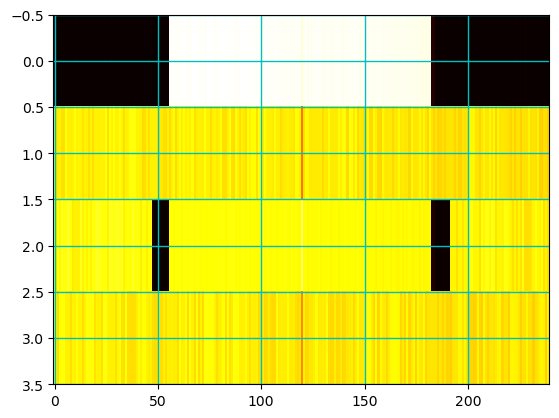

In [13]:
## OFDM Demodulator Object
ofdmDemodulator = OFDMDemodulator(fftSize, lengthCP[1])
pssStartIndex   = pssPeakIndices
# pssStartIndex   = pssPeakIndices[0][0]
rxGrid          = ofdmDemodulator((rx_samples.reshape(1,-1))[...,pssStartIndex:(pssStartIndex+4*(fftSize+lengthCP[1]))])

ssbSCSoffset   = int((fftSize-Neff)/2+ssbRGobject.startingSubcarrierIndices)
ssbEstimate    = rxGrid[:,:,ssbSCSoffset:(ssbSCSoffset+240)]

# Plot SSB
fig, ax = plt.subplots()
plt.imshow(np.abs(ssbEstimate[0]), cmap = 'hot', interpolation='nearest', aspect = "auto")
ax = plt.gca();
ax.grid(color='c', linestyle='-', linewidth=1)
plt.show()


## SSB Grid: Transmitter and Receiver

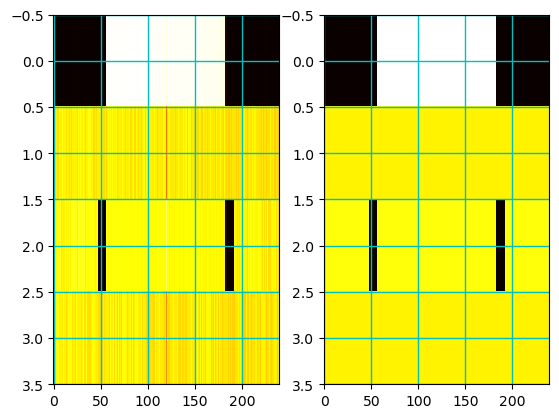

In [14]:
# Plot SSB
fig, ax = plt.subplots(1,2)
ax[0].imshow(np.abs(ssbEstimate[0]), cmap = 'hot', interpolation='nearest', aspect = "auto")
ax[0].grid(color='c', linestyle='-', linewidth=1)

ax[1].imshow(np.abs(ssb[0]), cmap = 'hot', interpolation='nearest', aspect = "auto")
ax[1].grid(color='c', linestyle='-', linewidth=1)

plt.show()

## Spectrum: Transmitted Grid and Received Grid

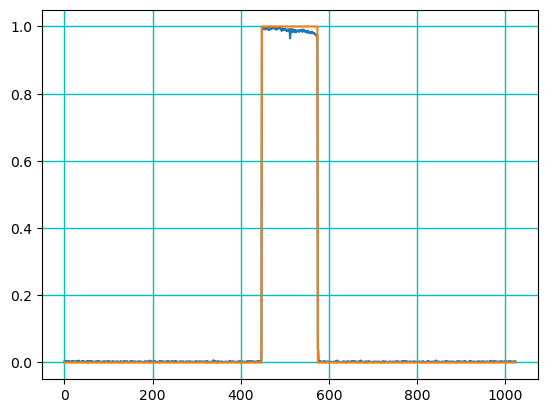

In [15]:
# Plot SSB
fig, ax = plt.subplots()
ax.plot(np.abs(rxGrid[0][0])/np.abs(rxGrid[0][0]).max())
ax.plot(np.abs(X[2])/np.abs(X[2]).max())
ax.grid(color='c', linestyle='-', linewidth=1)

plt.show()

## Parameter Estimation for SSB and PBCH

In [16]:
## N_ID_1 Estimation: SSS based
sssDetection   = SSSDetection(method="channelAssisted", N_ID2=rN_ID2)
rN_ID1         = sssDetection(ssbEstimate[0])
rN_ID          = 3*rN_ID1 + rN_ID2

## Generate SSB object to get DMRS and PBCH Indices
rxSSBobject    = SSB_Grid(rN_ID)
rxDMRSIndices  = rxSSBobject.dmrsIndices

## Generate DMRS sequence
dmrsDetection  = DMRSParameterDetection(int(rN_ID), nssbCandidatesInHrf, dmrsLen)
rssbIndex, rHrfBit = dmrsDetection(ssbEstimate[0])
rxDMRSobject   = DMRS("PBCH", int(rN_ID), int(rssbIndex), nssbCandidatesInHrf, rHrfBit)
rxDMRSseq      = rxDMRSobject(dmrsLen)

## Channel Estimation and PBCH Symbol Equalization

In [17]:
## Estimating the channel at DMRS (t-f) location, interpolting for data (t-f) location and equalizing the symbols
## Object for Channel Estimation
chanEst        = ChannelEstimationAndEqualization(estimatorType = "ZF", interpolatorType = "NN")
rxPBCHIndices  = rxSSBobject.pbchIndices
pbchEstimate   = chanEst(ssbEstimate[0], rxDMRSseq[0], rxDMRSIndices, rxPBCHIndices)

## PBCH Decoding and Constellation

/home/tenet/miniconda3/envs/mysdr/lib/python3.11/site-packages/toolkit5G/ChannelCoder/PolarCoder/polarDecoder.py:494: UserWarning: Required ressource allocation is large for the selected blocklength. Consider option `cpu_only=True`.
  warnings.warn("Required ressource allocation is large " \


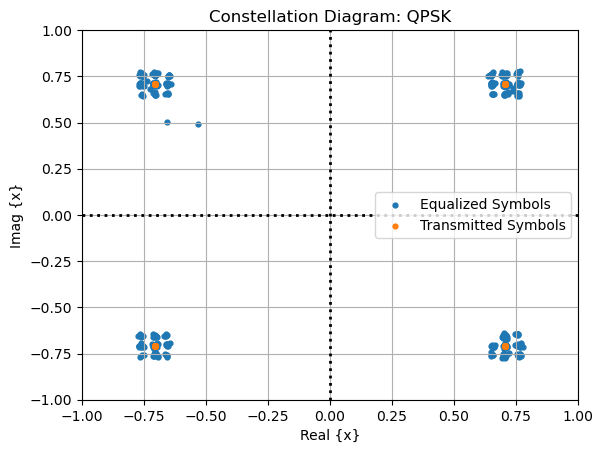

In [18]:
## PBCH Chain for Decoding information
polarDecoder   = "SCL"
symbolDemapper = "maxlog"
# extractMIBinfo = False
extractMIBinfo = True
# carrierFreq, cellID, nssbCandidatesInHrf, ssbIndex, polarDecType, symbolDemapperType
pbchDecoder    = PBCHDecoder(center_frequency, int(rN_ID), nssbCandidatesInHrf, rssbIndex, polarDecoder, symbolDemapper)
rxMIB, check   = pbchDecoder(pbchEstimate, 10, extractMIBinfo)


fig, ax = plt.subplots()
ax.scatter(np.real(pbchEstimate), np.imag(pbchEstimate), s = 12, label = "Equalized Symbols")
ax.scatter(np.real(pbchSymbols), np.imag(pbchSymbols), s = 12, label = "Transmitted Symbols")
ax.grid()
ax.axhline(y=0, ls=":", c="k", lw = 2)
ax.axvline(x=0, ls=":", c="k", lw = 2)
ax.set_xlim([-1,1])
ax.set_ylim([-1,1])
ax.set_xlabel("Real {x}")
ax.set_ylabel("Imag {x}")
ax.set_title("Constellation Diagram: QPSK")
ax.legend(loc = "best")
plt.show()

In [19]:
pbchDecoder.mibRx.displayParameters(0)

Carrier Frequency:	1000000000.0
ChoiceBit:  		1
nSsbCandidatesInHrf: 	4
subCarrierSpacingCommon:15000
DMRSTypeAPosition: 	typeA
controlResourceSet0:	5
searchSpace0: 		11
cellBarred: 		notBarred
intraFreqReselection: 	allowed
systemFrameNumber: 	358
ssbSubCarrierOffset: 	3
HRFBit: 		1
iSSBindex: 		0


In [20]:
pbchObject.mib.displayParameters(0)

Carrier Frequency:	1000000000.0
ChoiceBit:  		1
nSsbCandidatesInHrf: 	4
subCarrierSpacingCommon:15000
DMRSTypeAPosition: 	typeA
controlResourceSet0:	5
searchSpace0: 		11
cellBarred: 		notBarred
intraFreqReselection: 	allowed
systemFrameNumber: 	358
ssbSubCarrierOffset: 	3
HRFBit: 		1
iSSBindex: 		0


## Performance Verification

In [23]:
if (rN_ID == N_ID):
    print("[Success]: Cell-IDs correctly detected!")
else:
    if (rN_ID1 != N_ID1 and rN_ID2 != N_ID2):
        print("[Failed]: Receiver couldn't detect the Cell-ID1 and cell-ID2 correctly!")
    elif(rN_ID1 != N_ID1):
        print("[Failed]: Receiver couldn't detect the Cell-ID1 correctly!")
    else:
        print("[Failed]: Receiver couldn't detect the cell-ID2 correctly!")
        
if (rssbIndex == ssbIndex[0]):
    print("[Success]: DMRS parameters correctly detected!")
else:
    print("[Failed]: Receiver couldn't detect the ssbIndex correctly!")
    
## Computing BER: Coded and Uncoded
numUEs = 1
nBatch = 1
uncodedBER     = np.zeros((numUEs, nBatch))
codedBER       = np.zeros((numUEs, nBatch))

bitEst         = pbchDecoder.llr.copy()
bitEst[pbchDecoder.llr  > 0]   = 1
bitEst[pbchDecoder.llr  < 0]   = 0
uncodedBER = np.mean(np.abs(bitEst - pbchObject.scr2bits[0]))
codedBER   = np.mean(np.abs(pbchDecoder.pbchDeInterleavedBits - pbchObject.mibSequence[0]))

print(" (uncoded-BER, codedBER): "+str((uncodedBER, codedBER)))

[Success]: Cell-IDs correctly detected!
[Success]: DMRS parameters correctly detected!
 (uncoded-BER, codedBER): (0.0, 0.0)


In [22]:
pssChannel = ssbEstimate[0][sssDetection.pssInd]/sssDetection.pssSeq
sssChannel = ssbEstimate[0][sssDetection.sssInd]/SSS(N_ID1,N_ID2)().flatten()